## **Import and Install dependencies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [ ]:
import cv2
import numpy as np
import os
import time
import mediapipe as mp
from matplotlib import pyplot as plt

## Keypoints using MP Holistic


In [ ]:
mp_holistic = mp.solutions.holistic #holistic model
mp_drawing = mp.solutions.drawing_utils #drawing utilities

In [ ]:
def mediapipe_detection(image, model):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Color conversion BGR -> RGB
  image.flags.writeable = False                   # disable Image writeable
  results = model.process(image)                  # Make Holistic Predictions
  image.flags.writeable = True                    # enable Image Writeable
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Color conversion RGB -> BGR
  return image, results

In [ ]:
def draw_landmarks(image, results):
  mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)       # Draw face Connections
  mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)        # Draw pose Connections
  mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)   # Draw left hand Connections
  mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)  # Draw right hand Connections

In [78]:
vid_path = '/content/drive/My Drive/SASL_Vowels/A/A_72.mp4'
cap = cv2.VideoCapture(vid_path)
last_fr = None
last_res = None

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.1, min_tracking_confidence=0.5) as holistic:
  # process the video
  while cap.isOpened():

    # read frame
    ret, frame = cap.read()

    # break if there are no frames to be read
    if not ret:
          break
    
    # make detections
    image, results = mediapipe_detection(frame, holistic)
    if results.right_hand_landmarks:
      #print(results.right_hand_landmarks)
      #cv2_imshow( frame)
      last_fr = frame
      last_res = results

    # live web cam
      #draw_landmarks(image, results)
      #cv2_imshow(image)

    # breake if i say so
    if cv2.waitKey(10) and 0xff == ord('q'):
      break
  cv2.destroyAllWindows()
  cap.release()


In [79]:
draw_landmarks(last_fr, last_res)

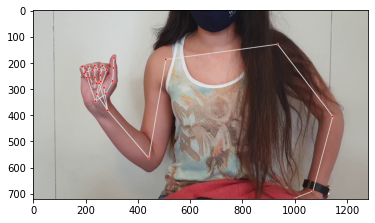

In [80]:
plt.imshow(cv2.cvtColor(last_fr, cv2.COLOR_BGR2RGB))

In [ ]:
results.left_hand_landmarks

In [ ]:
from google.colab.patches import cv2_imshow
list_ = os.listdir('/content/drive/My Drive/SASL_Vowels/A');
# vid_path = '/content/drive/My Drive/SASL_Vowels/A/A_9.mp4'

vid_frames_count = []
src = '/content/drive/My Drive/SASL_Vowels/I'

for video_file in os.listdir(src):

    vid_path = os.path.join(src,video_file)
    cap = cv2.VideoCapture(vid_path)
    frames_count = 0
    while cap.isOpened():
      ret, frame = cap.read()
      if not ret:
          break
      frames_count = frames_count + 1
      #cv2_imshow( frame)
      cv2.waitKey(1) & 0xff
    
    if os.path.exists(vid_path) and frames_count < 50:
      print('video: ', video_file, ' has ', frames_count, 'frames')
      os.remove(vid_path)
    else:
      vid_frames_count.append(frames_count)

    cv2.destroyAllWindows()
    cap.release()

vid_frames_count
len(vid_frames_count)

74

Play Video Function

In [ ]:
def play_video(src):
  if os.path.exists(src):
  

In [ ]:
vid_frames_count

[120,
 76,
 76,
 76,
 118,
 71,
 71,
 71,
 120,
 120,
 120,
 120,
 112,
 115,
 120,
 115,
 91,
 91,
 91,
 91,
 91,
 91,
 91,
 91,
 82,
 82,
 83,
 83,
 85,
 85,
 82,
 82,
 91,
 91,
 86,
 86,
 82,
 82,
 90,
 90,
 80,
 80,
 80,
 80,
 82,
 82,
 76,
 76,
 75,
 75,
 82,
 82,
 85,
 85,
 70,
 70,
 77,
 77,
 82,
 82,
 87,
 87,
 82,
 82,
 80,
 80,
 91,
 91,
 91,
 91]